## Train model

#### Import Necessary Modules

In [5]:
import tensorflow as tf 
import pandas as pd
import numpy as np
import nltk
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense,Embedding,Bidirectional,LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tree_stem import stem_word, word_to_vec
from tokenize_uk import tokenize_words
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


topics:
0 - economics
1 - politics
2 - sports
3 - entertainment
4 - technology


In [2]:
df = pd.read_csv('messages_dataset.csv') # load dataset

In [3]:
class_name = ['economics', 'politics', 'sports', 'entertainment', 'technology']

In [4]:
df.sample(frac=1).head()

,message,topic
41688,8-серійний готичний мінісеріал Майка Фленаґана...,4
39260,Google змінює правила Play Store — обов'язково...,4
54,Кількість IT-фахівців у Закарпатті з початку в...,0
42516,Ubisoft виводить з експлуатації сервери десятк...,4
34262,Вистава Наталії Могилевської «Доньки»\r\n\r\nВ...,3


#### Stemming and Lemmatize

In [5]:
print(stem_word('захоплювати'))
print(stem_word('захоплює'))
print(stem_word('захоплюється'))

захоплю
захоплю
захоплю


In [6]:
df.topic.value_counts()

topic
1    11542
4     9510
2     8594
3     8114
0     6110
Name: count, dtype: int64

#### Data Cleaning

In [7]:
ukrainian_stopwords = list(pd.read_csv("stopwords_ua.txt", header=None, names=['stopwords']).stopwords)
print(ukrainian_stopwords[:10])

['а', 'аби', 'абиде', 'абиким', 'абикого', 'абиколи', 'абикому', 'абикуди', 'абихто', 'абичий']


In [8]:
def get_dataset_equally(df):
    grouped = df.groupby(['topic'])
    smallest = grouped.count().min().values
    try: # Pandas 1.1.0+
        return grouped.sample(smallest)
    except AttributeError: # Pre-Pandas 1.1.0
        return grouped.apply(lambda df: df.sample(smallest))
df = get_dataset_equally(df)
df.topic.value_counts()


topic
0    6110
1    6110
2    6110
3    6110
4    6110
Name: count, dtype: int64

In [ ]:
# clean dataset messages
def clean_message(message):
    text = re.sub("https?:\/\/[\w+.\/]+", " ", str(message))
    text = re.sub('[^a-zабвгґдеєжзиіїйклмнопрстуфхцчшщьюя]', ' ', str(text)).lower()
    sen = re.sub(' +',' ',str(message))
    words = tokenize_words(sen)
    sen = []
    for word in words:
        if word not in ukrainian_stopwords:
            try:
                sen.append(stem_word(word))
            except:
                sen.append(word)

    text = ' '.join(sen)
    return text.strip()


In [ ]:

corpus = [] 
x = df.message
y = df.topic

for msg in x:
    corpus.append(clean_message(msg))

#np.save("training_words.npy", np.array(corpus))

In [10]:
corpus[199]

'лют виділ мільярд допомог країн мільярд військов допомог нада вигляд допомог країн озподіл мільярд млрд військов допомог млрд економічн підтрим млрд гуманітарн допомог во чер розподіл млрд військов допомог млрд бро спорядженн зброєнн техні склад іністерств оборон надан рам президентськ скорочен товар вироблен швид доставлен млрд опомо сфер безпе інансуванн ентагон пообіця інвесту збільшенн кільк озброєн навчанн консультуванн логісти обладнанн рам kraine ecurity ssistance nitiative млрд рант кред озброєнн обладнанн закупів озброєнн техні програм акордонн військов фінансуванн виданн he ashington ost вказу зашкалююч цифр порівню лан аршалл поправ інфляці скла мільярд долар ро bankinvest'

In [11]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index)+1

print(f"total words in corpus {total_words}")

total words in corpus 63161


In [12]:
text_sequence = tokenizer.texts_to_sequences(corpus)

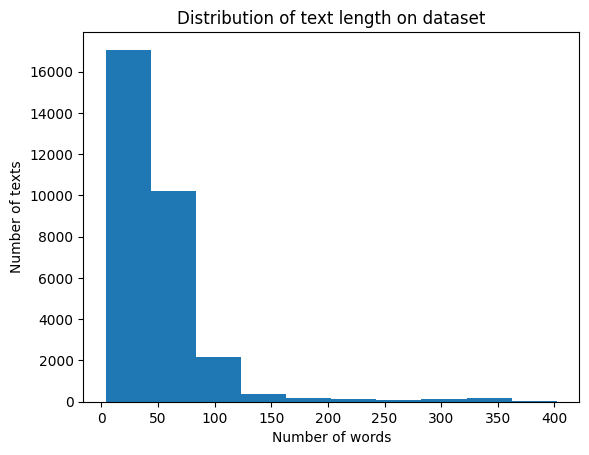

In [13]:
from matplotlib import pyplot as plt


def len_distribution(X):
    x = [len(n) for n in X]

    plt.hist(x)
    plt.xlabel('Number of words')
    plt.ylabel('Number of texts')
    plt.title('Distribution of text length on dataset')
    plt.show()
len_distribution(text_sequence[:30550])

In [14]:
text_sequence[0]

[1014,
 1594,
 3059,
 3674,
 2425,
 333,
 1344,
 1032,
 46,
 296,
 318,
 3493,
 483,
 541,
 296,
 431,
 38280,
 530,
 2317,
 2053,
 306,
 436,
 65]

In [29]:
opt_len = 250
text_padded = pad_sequences(text_sequence,maxlen=opt_len,padding='post')

In [30]:
text_padded

array([[ 1014,  1594,  3059, ...,     0,     0,     0],
       [   64,  1829,  1785, ...,     0,     0,     0],
       [ 2337,   854,   150, ...,     0,     0,     0],
       ...,
       [ 6919,  3417,     5, ...,     0,     0,     0],
       [18613,   202,   803, ...,     0,     0,     0],
       [ 1560,  6103,   550, ...,     0,     0,     0]])

#### Split Our Data

In [31]:
x_train,x_test,y_train,y_test = train_test_split(text_padded,y,test_size=0.2,random_state=42)

In [32]:
x_train.shape,y_train.shape, x_test.shape, y_test.shape

((24440, 250), (24440,), (6110, 250), (6110,))

In [33]:
len(x_train),len(y_train),len(x_test),len(y_test)

(24440, 24440, 6110, 6110)

#### Model Building

In [64]:
model = tf.keras.models.Sequential([
    Embedding(total_words,200,input_length=opt_len),
    Bidirectional(LSTM(100,return_sequences=True)),
    Bidirectional(LSTM(50)),
    Dense(5,activation='softmax')
])

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 200)          12632200  
                                                                 
 bidirectional_4 (Bidirecti  (None, 250, 200)          240800    
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 100)               100400    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 5)                 505       
                                                                 
Total params: 12973905 (49.49 MB)
Trainable params: 12973905 (49.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


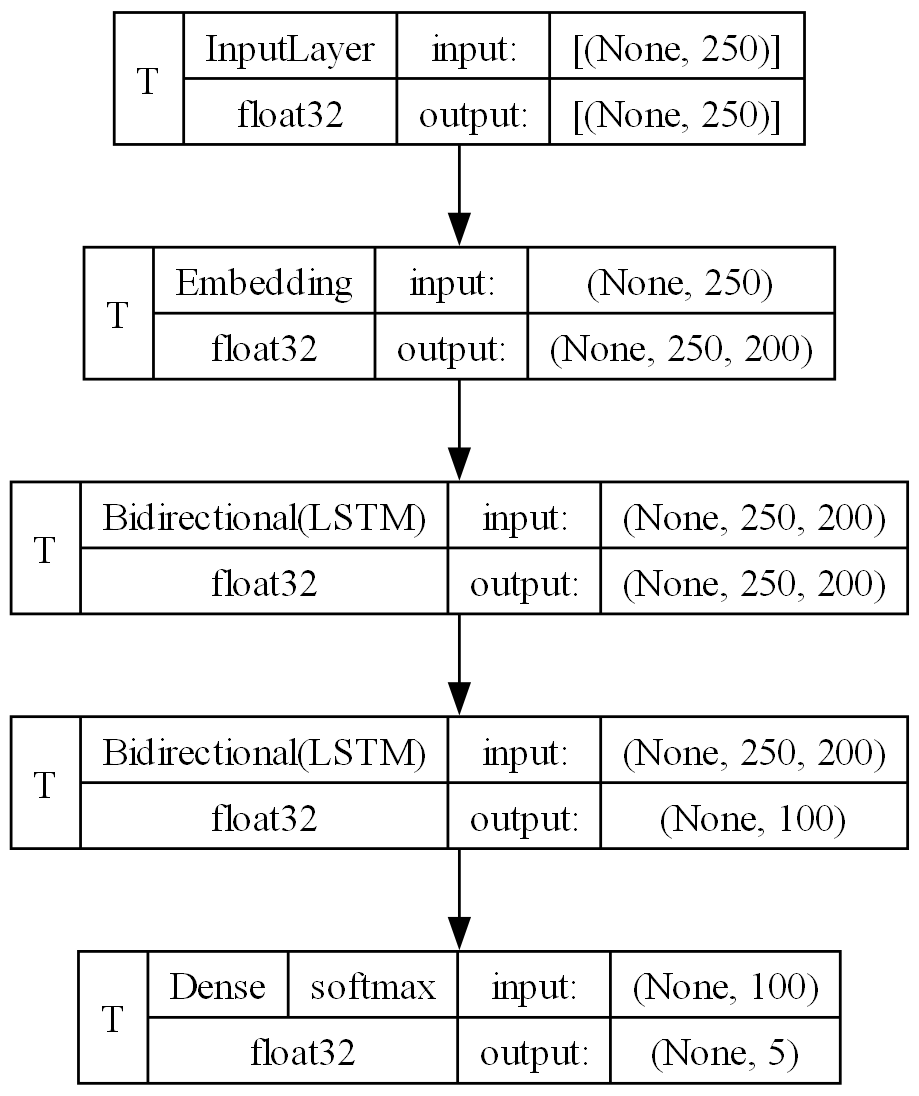

In [36]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=True,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True,
)


In [65]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['acc'])
filepath="lstm-bidir-250words-rlr-16batch-{epoch:02d}-{val_acc:.2f}.keras"
checkpoint = ModelCheckpoint(filepath, save_weights_only=False, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='acc',patience=4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4,
                              patience=5, min_lr=0.0001)

In [66]:
history2 = model.fit(x_train,y_train, batch_size=16,
                    validation_data=(x_test,y_test), validation_batch_size=16,
                    callbacks=[checkpoint, early_stopping, reduce_lr],
                    epochs=5)

Epoch 1/5
1528/1528 [==============================] - ETA: 0s - loss: 0.3749 - acc: 0.8638
Epoch 1: val_acc improved from -inf to 0.94779, saving model to lstm-bidir-250words-rlr-16batch-01-0.95.keras
1528/1528 [==============================] - 705s 455ms/step - loss: 0.3749 - acc: 0.8638 - val_loss: 0.1679 - val_acc: 0.9478 - lr: 0.0010
Epoch 2/5
1528/1528 [==============================] - ETA: 0s - loss: 0.1180 - acc: 0.9654
Epoch 2: val_acc did not improve from 0.94779
1528/1528 [==============================] - 671s 439ms/step - loss: 0.1180 - acc: 0.9654 - val_loss: 0.1779 - val_acc: 0.9444 - lr: 0.0010
Epoch 3/5
1528/1528 [==============================] - ETA: 0s - loss: 0.0652 - acc: 0.9804
Epoch 3: val_acc did not improve from 0.94779
1528/1528 [==============================] - 672s 440ms/step - loss: 0.0652 - acc: 0.9804 - val_loss: 0.2106 - val_acc: 0.9416 - lr: 0.0010
Epoch 4/5
1528/1528 [==============================] - ETA: 0s - loss: 0.0478 - acc: 0.9869
Epoch 4: v

In [67]:
model = tf.keras.models.load_model("lstm-bidir-250words-16batch-04-0.95.keras")

history_fine_2 = model.fit(x_train,y_train, batch_size=8,
                    validation_data=(x_test,y_test), validation_batch_size=8,
                    callbacks=[checkpoint, early_stopping, reduce_lr],
                    epochs=10,
                    initial_epoch=4)

Epoch 5/10
3055/3055 [==============================] - ETA: 0s - loss: 0.0333 - acc: 0.9903
Epoch 5: val_acc did not improve from 0.94779
3055/3055 [==============================] - 1341s 436ms/step - loss: 0.0333 - acc: 0.9903 - val_loss: 0.2482 - val_acc: 0.9403 - lr: 0.0010
Epoch 6/10
3055/3055 [==============================] - ETA: 0s - loss: 0.0233 - acc: 0.9926
Epoch 6: val_acc did not improve from 0.94779
3055/3055 [==============================] - 1385s 454ms/step - loss: 0.0233 - acc: 0.9926 - val_loss: 0.2513 - val_acc: 0.9432 - lr: 0.0010
Epoch 7/10
3055/3055 [==============================] - ETA: 0s - loss: 0.0168 - acc: 0.9955
Epoch 7: val_acc did not improve from 0.94779
3055/3055 [==============================] - 1360s 445ms/step - loss: 0.0168 - acc: 0.9955 - val_loss: 0.3049 - val_acc: 0.9358 - lr: 0.0010
Epoch 8/10
3055/3055 [==============================] - ETA: 0s - loss: 0.0103 - acc: 0.9972
Epoch 8: val_acc did not improve from 0.94779
3055/3055 [==========

[0.9459902048110962, 0.9463174939155579, 0.9438624978065491, 0.9469721913337708, 0.9446808695793152, 0.9407528638839722, 0.9425531625747681, 0.9486088156700134, 0.9436988830566406, 0.9404255151748657, 0.943207859992981]


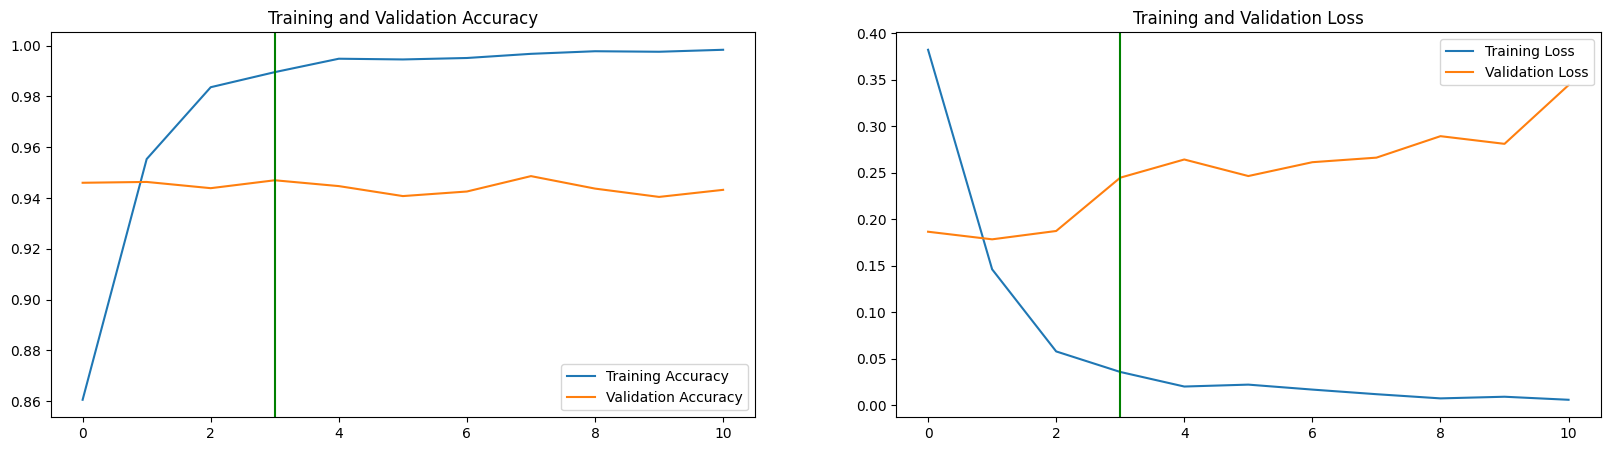

In [71]:
# show loss and accuracy
from matplotlib import pyplot as plt


def show_loss_accuracy(history):
  acc = history.history['acc'] + history_fine.history['acc']
  val_acc = history.history['val_acc'] + history_fine.history['val_acc']
  loss = history.history['loss'] + history_fine.history['loss']
  val_loss = history.history['val_loss'] + history_fine.history['val_loss']

  epochs_range = range(len(acc))
  print(val_acc)
  plt.figure(figsize=(20, 5))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.axvline(x = 3, color = 'g', label = 'axvline - full height')
  plt.title('Training and Validation Accuracy')
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.axvline(x = 3, color = 'g', label = 'axvline')
  plt.title('Training and Validation Loss')
  plt.show()
show_loss_accuracy(history)

In [73]:
model = tf.keras.models.load_model("lstm-bidir-250words-16batch-04-0.95.keras")
model.evaluate(x_test,y_test)

191/191 [==============================] - 31s 135ms/step - loss: 0.2446 - acc: 0.9470


[0.24459607899188995, 0.9469721913337708]

In [74]:
from sklearn.metrics import confusion_matrix,classification_report

predicted = model.predict(x_test)
prediction= []
for i in predicted:
    label = np.argmax(i)
    prediction.append(label)

191/191 [==============================] - 26s 124ms/step


In [118]:
print(y_test[170:180])
print(prediction[170:180])

795      0
18117    2
22767    2
32062    3
1432     0
3605     0
4357     0
594      0
20524    2
14965    1
Name: topic, dtype: int64
[0, 2, 2, 3, 0, 0, 0, 0, 1, 1]


In [165]:
print(df.loc[[3504]])

                                                message  topic
3504  Google запустив міні-гру, де треба з танку стр...      0


In [166]:
wrong_predictions = y_test[prediction != y_test]
wrong_predictions_value = [prediction[i] for i in y_test[prediction != y_test]]
print('test_labels:')
print(wrong_predictions[:20])
print('predictions:')
print(len(wrong_predictions_value))

test_labels:
14145    1
3504     0
12119    1
43518    4
9347     1
13141    1
13210    1
12725    1
34506    4
4349     0
11007    1
20524    2
42994    4
5798     0
37371    4
25949    2
33339    3
9703     1
5929     0
5717     0
Name: topic, dtype: int64
predictions:
324


#### Confusion Matrix

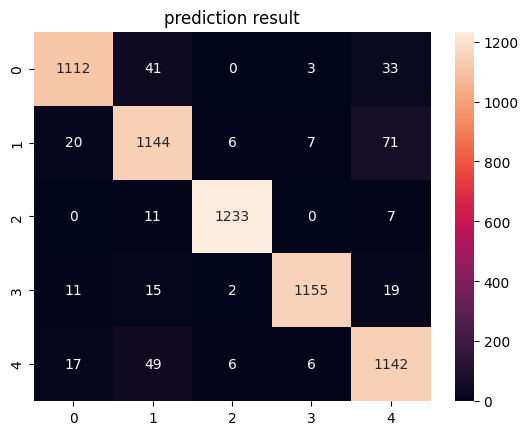

In [167]:
cm = confusion_matrix(y_test,prediction)

import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cm,
           annot=True,
           fmt='d')
plt.title('prediction result');

#### Classification report

In [168]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1189
           1       0.91      0.92      0.91      1248
           2       0.99      0.99      0.99      1251
           3       0.99      0.96      0.97      1202
           4       0.90      0.94      0.92      1220

    accuracy                           0.95      6110
   macro avg       0.95      0.95      0.95      6110
weighted avg       0.95      0.95      0.95      6110



In [51]:
test_sample = np.array(x_test[10].reshape(1, -1))

### Example Tech Document And Test The Model

In [192]:
text_input = ["""Рада запровадила акциз на нікотинові паучі (снюс). ㅤ (https://t.me/+B4pfPhGZkLM4MGYy)

Депутати Верховної Ради схвалили в цілому законопроєкт №10321-1 про приведення деяких норм у відповідність до закону України "Про Митний тариф України" та уточнення окремих положень. Документ запроваджує акциз для нової категорії групи підакцизних товарів – нікотинових подушечок ("паучів"). 

"Однією з новел законопроєкту є виокремлення та оподаткування нової категорії групи підакцизних товарів (так званих нікотинових подушечок "паучів"). Це принесе бюджету додатково 300 млн грн у рік"
 – повідомив ініціатор законопроєкту, голова парламентського комітету з податків та фінансів Данило Гетманцев."""]

text = clean_message(text_input)


print(text)

sequence = tokenizer.texts_to_sequences([text])
print(sequence)
embedding_docs = pad_sequences(sequence,padding='post',maxlen=opt_len)
print(text_input)
print('topic is: {}'.format(class_name[np.argmax(model.predict(embedding_docs))]))

ад запровад акциз нікотин пауч снюс n n епута ерховн ад схвал ціл законопроєкт приведенн норм відповідн закон країн ро итн тариф країн уточненн окрем положен окумент запроваджу акциз нов категорі груп підакцизн товар нікотинов подушеч пауч n n дні новел законопроєкт виокремленн оподаткуванн нов категорі груп підакцизн товар зван нікотинов подушеч пауч принес бюджет додатков мл грн n повідом ініціатор законопроєкт голов парламентськ комітет податк фінанс ан етманцев
[[178, 1472, 2531, 20734, 1, 1, 2528, 2528, 8449, 1072, 178, 1478, 140, 1487, 11414, 1805, 748, 268, 2, 4, 5853, 1327, 2, 10162, 314, 7672, 4278, 4633, 2531, 7, 935, 98, 6800, 222, 44085, 57541, 1, 2528, 2528, 6589, 12674, 1487, 1, 1259, 7, 935, 98, 6800, 222, 1923, 44085, 57541, 1, 4076, 239, 448, 20, 3, 2528, 116, 9621, 1487, 252, 3200, 937, 631, 696, 414, 2783]]
['Рада запровадила акциз на нікотинові паучі (снюс). ㅤ (https://t.me/+B4pfPhGZkLM4MGYy)\n\nДепутати Верховної Ради схвалили в цілому законопроєкт №10321-1 про при

In [54]:
sequence = tokenizer.texts_to_sequences([text])
print(sequence)
embedding_docs = pad_sequences(sequence,padding='post',maxlen=opt_len)

[[506, 796, 39, 5673, 24, 3197, 1299, 37748, 2528, 2528, 25622, 8176, 151, 2, 506, 796, 39, 5673, 24, 281, 1405, 692, 206, 3197, 2528, 2528, 4, 116, 3582, 8433, 5589, 1299, 37748, 778, 91, 4826, 1160, 2528, 2528, 506, 3197, 899, 23, 35, 796, 39, 5673, 248, 1691, 15647, 32708, 1270, 999, 18134, 161, 2076, 1405, 8196, 2001, 1667, 698, 1235, 1868, 3606, 108, 81, 206, 373, 1412, 30893, 211, 4326, 1405, 406, 1299, 37748, 2528]]


In [55]:
class_name[np.argmax(model.predict(embedding_docs))]

1/1 [==============================] - 0s 49ms/step


'technology'

Wow Finally we Got an Correct answer